# [Genieclust](https://github.com/gagolews/genieclust) Tutorial
## The Genie Algorithm - The Basics

Author: [Marek Gagolewski](http://www.gagolewski.com)

> **It is a draft version of the tutorial distributed in the hope that it will be useful.**


*Genie* is a new hierarchical clustering linkage criterion: the Genie algorithm
links two clusters in such a way that a chosen economic inequity measure
(here, the Gini index) of the cluster sizes does not increase drastically
above a given threshold. It most often outperforms
the Ward or average linkage, k-means, spectral clustering,
DBSCAN, Birch, and others in terms of the clustering
quality on benchmark data while retaining the single linkage speed.
It is suitable for clustering of large data sets.

See: Gagolewski M., Bartoszuk M., Cena A.,
Genie: A new, fast, and outlier-resistant hierarchical clustering algorithm,
Information Sciences 363, 2016, pp. 8-23. 
doi:[10.1016/j.ins.2016.05.003](http://dx.doi.org/10.1016/j.ins.2016.05.003) 
    

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
import genieclust

# Breaking the Ice

Let's load an example benchmark set together with the true corresponding clustering
(as given by an expert). The `jain` dataset comes from (A. Jain, M. Law, Data clustering: A user’s dilemma,
Lecture Notes in Computer Science 3776, 2005, pp. 1-10).

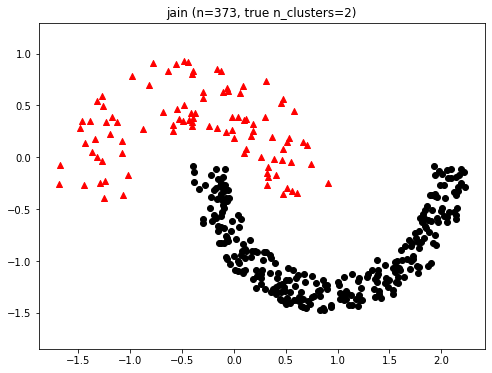

In [2]:
path = os.path.join("..", "benchmark_data")
dataset = "jain"

# Load an example 2D dataset
X = np.loadtxt("%s/%s.data.gz" % (path,dataset), ndmin=2)

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# Let's make them more Python-ish by subtracting 1.
labels_true = np.loadtxt("%s/%s.labels0.gz" % (path,dataset), dtype=np.intp)-1

# The number of unique labels gives the true cluster count:
n_clusters = len(np.unique(labels_true))

# Center and scale (proportionally in all the axes) all the points:
# Note: this is NOT a standardization of all the variables.
X = (X-np.mean(X))/np.std(X, ddof=1)

# Plot the dataset
genieclust.plots.plot_scatter(X, labels_true)
plt.title("%s (n=%d, true n_clusters=%d)"%(dataset, X.shape[0], n_clusters))
plt.axis("equal")
plt.show()

Let's apply the Genie algorithm (with the default/recommended `gini_threshold` value):

In [3]:
g = genieclust.genie.Genie(n_clusters=n_clusters)
print(g)

Genie(M=1, allow_cast_float32=True, exact=True, gini_threshold=0.3,
      n_clusters=2, n_neighbors=-1, nn_params=None, postprocess='boundary')


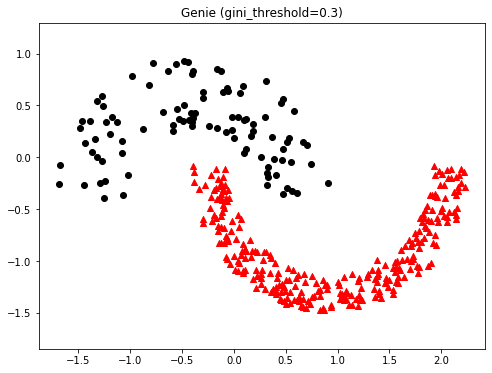

In [4]:
labels_genie = g.fit_predict(X)
genieclust.plots.plot_scatter(X, labels_genie)
plt.title("Genie (gini_threshold=%g)"%(g.gini_threshold))
plt.axis("equal")
plt.show()

We can compare the resulting clustering with the reference one by computing, for example, the confusion matrix.

In [5]:
# Compute the confusion matrix (with pivoting)
confusion_matrix = genieclust.compare_partitions.normalized_confusion_matrix(labels_true[labels_true>=0], labels_genie[labels_true>=0])
pd.DataFrame(confusion_matrix)

,0,1
0,276,0
1,0,97


The above confusion matrix can be summarized using some cluster similarity measures, like the Adjusted Rand Index (`ar`).

In [6]:
# See also: sklearn.metrics.adjusted_rand_score()
genieclust.compare_partitions.adjusted_rand_score(labels_true[labels_true>=0], labels_genie[labels_true>=0])

1.0

The Rand score of $1.0$ indicates a perfect match between the reference partition and the one that was generated by the Genie algorithm.

# A Comparison with k-means

For the sake of comparison, let's apply the k-means algorithm on the same dataset.

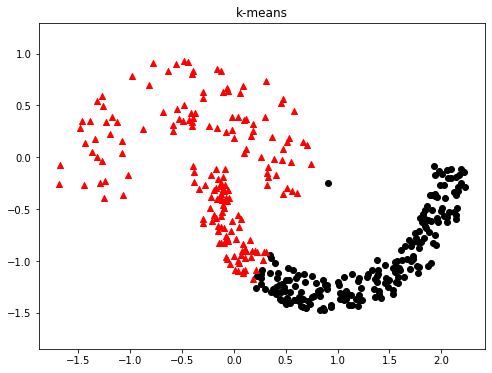

In [7]:
import sklearn.cluster
labels_kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit_predict(X)
genieclust.plots.plot_scatter(X, labels_kmeans)
plt.title("k-means")
plt.axis("equal")
plt.show()

It is well known that the k-means algorithm can only split the input space into
convex regions (compare the notion of the [Voronoi diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram)).
So we shouldn't be much surprised with this result.

In [8]:
# Compute the confusion matrix for the k-means output
confusion_matrix_kmeans = genieclust.compare_partitions.normalized_confusion_matrix(labels_true[labels_true>=0], labels_kmeans[labels_true>=0])
pd.DataFrame(confusion_matrix_kmeans)

,0,1
0,197,79
1,1,96


In [9]:
# Cluster similarity measures for k-means
genieclust.compare_partitions.adjusted_rand_score(labels_true[labels_true>=0], labels_kmeans[labels_true>=0])

0.3241080446115835

The adjusted Rand score of $\sim 0.3$ indicates a far-from-perfect fit.

# A Comparison with HDBSCAN

Finally, let's make a comparison against a version of the DBSCAN (density-based) algorithm.
The original DBSCAN relies on a somehow magical `eps` parameter, which is hard to tune.
Fortunately, the [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) package implements its robustified variant, which makes the algorithm much easier to use.

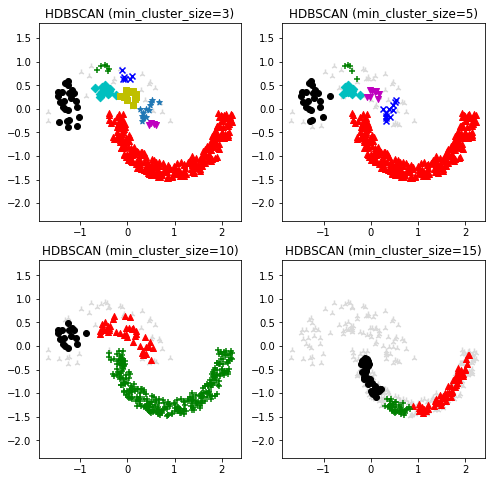

In [10]:
import hdbscan
mcs = [3, 5, 10, 15]
plt.rcParams["figure.figsize"] = (8,8)
for i in range(len(mcs)):
    h = hdbscan.HDBSCAN(min_cluster_size=mcs[i])
    labels_hdbscan = h.fit_predict(X)
    plt.subplot(2, 2, i+1)
    genieclust.plots.plot_scatter(X, labels_hdbscan)
    plt.title("HDBSCAN (min_cluster_size=%d)"%h.min_cluster_size)
    plt.axis("equal")
plt.show()

Black dots denote "noise" points - we'll get back to them later.

In HDBSCAN, the `min_cluster_size` parameter affects the "granularity" of the obtained clusters.
Its default value was set to:

In [11]:
hdbscan.HDBSCAN().min_cluster_size

5

Unfortunately, we cannot easily guess how many clusters will be generated by this method. At a first glance,
it would seem that `min_cluster_size` should lie somewhere between 10 and 15, but...

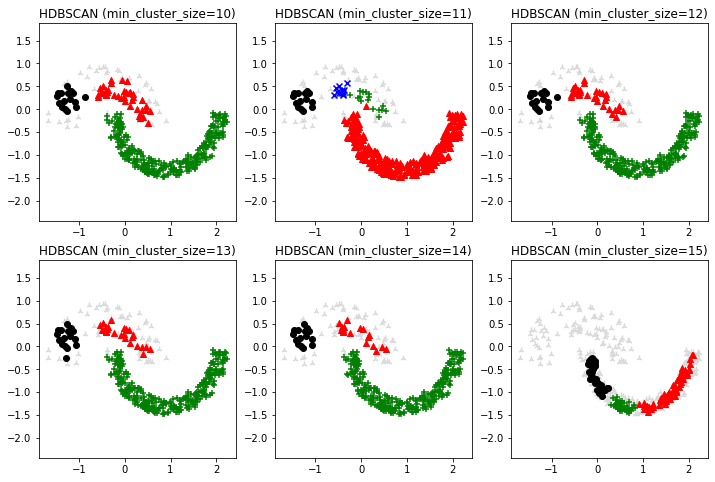

In [12]:
mcs = range(10, 16)
plt.rcParams["figure.figsize"] = (12,8)
for i in range(len(mcs)):
    h = hdbscan.HDBSCAN(min_cluster_size=mcs[i])
    labels_hdbscan = h.fit_predict(X)
    plt.subplot(2, 3, i+1)
    genieclust.plots.plot_scatter(X, labels_hdbscan)
    plt.title("HDBSCAN (min_cluster_size=%d)"%h.min_cluster_size)
    plt.axis("equal")
plt.show()

Strangely enough, `min_cluster_size` of $11$ generates 4 clusters, whereas $11\pm 1$ - only 3 of them.
On the other hand, the Genie algorithm belongs to the group of *hierarchical agglomerative methods* - it's able to generate
a sequence of *nested* partitions, which means that by incrementing `n_clusters`, we split one and only one cluster into two subgroups.
This makes the resulting partitions more stable.

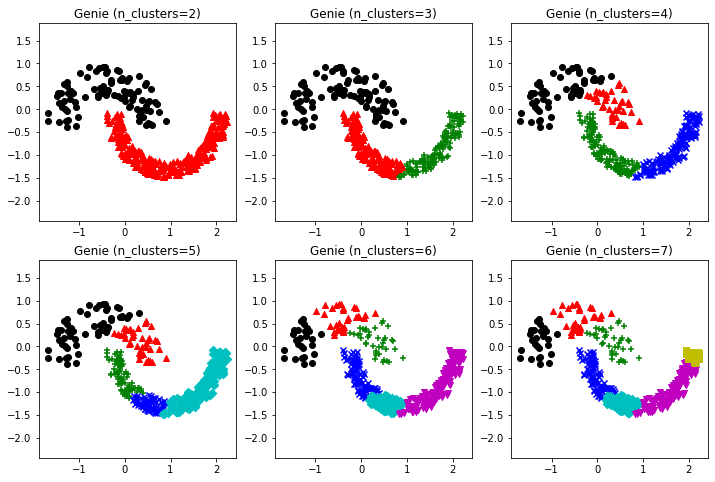

In [13]:
ncl = range(2, 8)
plt.rcParams["figure.figsize"] = (12,8)
for i in range(len(ncl)):
    g = genieclust.genie.Genie(n_clusters=ncl[i])
    labels_genie = g.fit_predict(X)
    plt.subplot(2, 3, i+1)
    genieclust.plots.plot_scatter(X, labels_genie)
    plt.title("Genie (n_clusters=%d)"%(g.n_clusters,))
    plt.axis("equal")
plt.show()

Finally, we note that HDBSCAN marked a few of the input observations as "noise" (the black points).
It turns out that the Genie algorithm is also equipped with such a feature (on demand), see [the next tutorial](example_noisy.ipynb).